In this assignment you are generating sample images of Simpsons with deep convolutional generative adversarial networks (DCGANs). 

You need to do the following:

1- Read and understand this tutorial: https://towardsdatascience.com/image-generator-drawing-cartoons-with-generative-adversarial-networks-45e814ca9b6b (Links to an external site.)Links to an external site.

2- Download the dataset and the source code (Jupyter Notebook) given in the tutorial. Analyze and understand the code. (Note: you need to work on images in the "cropped" folder in the dataset)

3- The code is implemented using Tensorflow. You need to change it to fully uses Keras. Please keep the structure of the code (name of the functions and so on) so it is easier to follow your code. 

4- Change the code to use resized images. The original images are 128x128 but you need to resize them to 64x64 before training. You need to make required adjustments in the network to accommodate this change. Thsi will make training faster too. 

5- Make sure you keep all the plotting parts of the code so you can observe how the system learns in each epoch. 

6- If training on Colab will be slow, you can only run it for 50 epochs (or as many as possible).  To test your code, you can run first one or two epochs. Once everything is working, then you can let it run for 50 or 300 epochs. 

7- If you wanted to run it faster, you can get free trials of GPU instances on AWS or Google cloud. 

8- Submit the notebook with all the results included in the notebook. 



In [0]:
!pip install tqdm

In [0]:
import tensorflow as tf
from tqdm import tqdm

In [0]:
import tarfile, zipfile
import warnings
from keras.callbacks import History
from keras import applications
from keras.models import load_model

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
import tarfile, zipfile
from PIL import Image

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model

In [0]:
import zipfile
from glob import glob
import re

In [0]:
import random
from keras.layers import Input, Reshape, LeakyReLU, BatchNormalization, Conv2DTranspose, Flatten
from keras.initializers import TruncatedNormal

In [0]:
from keras.backend import shape, random_normal

In [0]:
from google.colab import files
uploaded = files.upload()

Saving simpsons-faces.zip to simpsons-faces.zip


In [0]:
tgz = zipfile.ZipFile('simpsons-faces.zip', 'r')
if not os.path.isdir('./dataset/'):
        tgz.extractall(path='./dataset/')
        tgz.close()

In [0]:
tgz_1 = zipfile.ZipFile('../content/dataset/cropped.zip', 'r')
if not os.path.isdir('./cropped/'):
        tgz_1.extractall(path='./cropped/')
        tgz_1.close()

In [0]:
CROPPED_DIR='../content/cropped'

In [0]:
IMG_SIZE = 64
X = []

exclude_img = ["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
"9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
"7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",
"7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
"6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
"4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
"2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
"1702","1281","1272","772","736","737","691","684","314","242","191"]

exclude_img = [s + ".png" for s in exclude_img]

In [0]:
!rm -rf /content/cropped/__MACOSX

In [0]:
!rm -rf /content/sample_data/g10.h5
!rm -rf /content/sample_data/g20.h5

In [0]:
from scipy import ndimage, misc

images = []
for root, dirnames, filenames in os.walk(CROPPED_DIR):
    for filename in filenames:
      if filename not in exclude_img:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            image_resized = misc.imresize(image, (64, 64))
            images.append(np.array(image_resized))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [0]:
images = np.array(images) / 255

In [0]:
images.shape

(9798, 64, 64, 3)

In [0]:
# Hyperparameters
NOISE_SIZE = 100
CHANNELS = 3
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 300 # For better results increase this value 
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 5
optimizer = Adam(0.0002, 0.5)

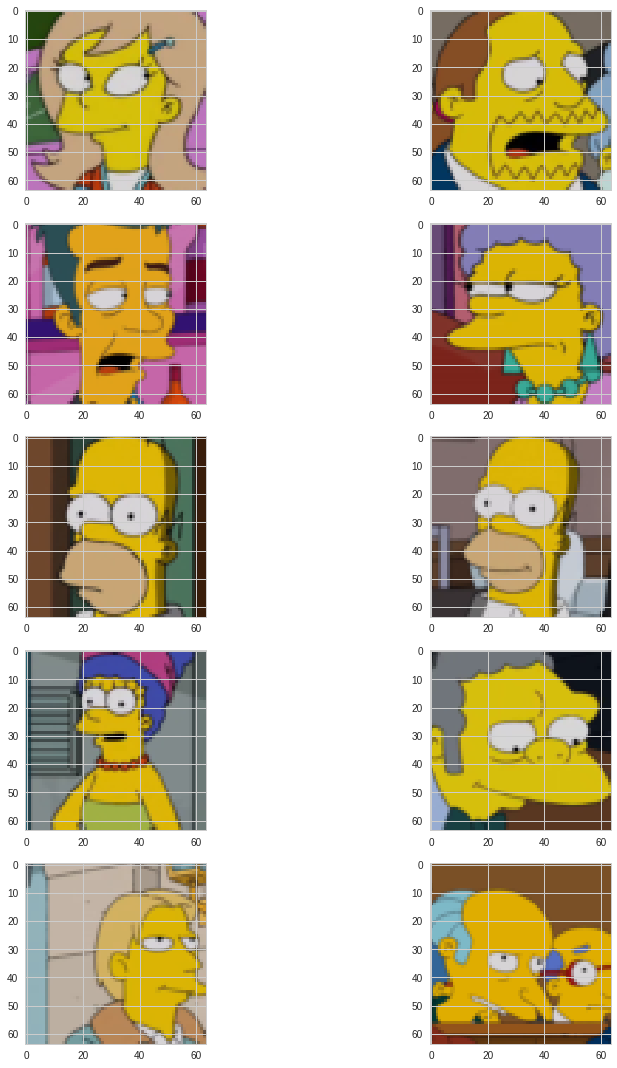

In [0]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,images.shape[0])
        ax[i,j].imshow(images[l])
        
plt.tight_layout()

In [0]:
# Setting random seeds

np.random.seed(123)
rn.seed(123)
tf.set_random_seed(123)

K.clear_session()

# Generator

In [0]:
def build_generator(noise_shape=(NOISE_SIZE,), debug=False):
 
  # 8x8x1024
  input = Input(noise_shape)
  x = Dense(8*8*1024, activation = "selu")(input)
  x = Reshape((8, 8, 1024))(x)
  x = LeakyReLU(alpha=0.3)(x)
  
  # 8x8x1024 -> 16x16x512
  x = Conv2DTranspose(
                      filters=512,
                      kernel_size=[5,5],
                      strides=[2,2],
                      padding="same",
                      kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
                      name="trans_conv1")(x)
  x = BatchNormalization(epsilon = EPSILON, name="batch_trans_conv1")(x)
  x = LeakyReLU(alpha=0.3, name="trans_conv1_out")(x)
  
  # 16x16x512 -> 32x32x256
  x = Conv2DTranspose(
                       filters=256,
                       kernel_size=[5,5],
                       strides=[2,2],
                       padding="same",
                       kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
                       name="trans_conv2")(x)
  x = BatchNormalization(epsilon=EPSILON, name="batch_trans_conv2")(x)
  x = LeakyReLU(alpha=0.3, name="trans_conv2_out")(x)
  
  # 32x32x256 -> 64x64x128
  x = Conv2DTranspose(
                       filters=128,
                       kernel_size=[5,5],
                       strides=[2,2],
                       padding="SAME",
                       kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
                       name="trans_conv3")(x)
  x = BatchNormalization(epsilon=EPSILON, name="batch_trans_conv3")(x)
  x = LeakyReLU(alpha=0.3, name="trans_conv3_out")(x)
  
  # 64x64x128 -> 64x64x64
  x = Conv2DTranspose(
                       filters=64,
                       kernel_size=[5,5],
                       strides=[1,1],
                       padding="SAME",
                       kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
                       name="trans_conv4")(x)
  x = BatchNormalization(epsilon=EPSILON, name="batch_trans_conv4")(x)
  x = LeakyReLU(alpha=0.3, name="trans_conv4_out")(x)
  
  # 64x64x64 -> 64x64x3
  logits = Conv2DTranspose(
                            filters=3,
                            kernel_size=[5,5],
                            strides=[1,1],
                            padding="SAME",
                            kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
                            name="logits")(x)
  out = Activation("tanh", name="out")(logits)
  
  model = Model(input, out)
  print("-- Generator -- ")
  model.summary()
  return model

In [0]:
build_generator(noise_shape=(100,), debug=False)

-- Generator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
trans_conv1 (Conv2DTranspose (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_trans_conv1 (BatchNorm (None, 16, 16, 512)       2048      
_________________________________________________________________
trans_conv1_out (LeakyReLU)  (None, 16, 16, 512)       0   

# Discriminator

In [0]:
def build_discriminator(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), debug=False):
  # 128*128*3 -> 64x64x64 
  input = Input(img_shape)
  x = Conv2D(filters=64,
             kernel_size=[5,5],
             strides=[2,2],
             padding="SAME",
             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
             name='conv1')(input)
  x = BatchNormalization(epsilon = EPSILON, name='batch_norm1')(x)
  x = LeakyReLU(alpha=0.3, name="conv1_out")(x)
  
  # 64x64x64-> 32x32x128 
  
  x = Conv2D(filters=128,
             kernel_size=[5, 5],
             strides=[2, 2],
             padding="SAME",
             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
             name='conv2')(x)
  x = BatchNormalization(epsilon = EPSILON, name='batch_norm2')(x)
  x = LeakyReLU(alpha=0.3, name="conv2_out")(x)
  
  # 32x32x128 -> 16x16x256 
  
  x = Conv2D(filters=256,
             kernel_size=[5, 5],
             strides=[2, 2],
             padding="SAME",
             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
             name='conv3')(x)
  x = BatchNormalization(epsilon = EPSILON, name='batch_norm3')(x)
  x = LeakyReLU(alpha=0.3, name="conv3_out")(x)
  
  # 16x16x256 -> 16x16x512
  x = Conv2D(filters=512,
             kernel_size=[5, 5],
             strides=[1, 1],
             padding="SAME",
             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
             name='conv4')(x)
  x = BatchNormalization(epsilon = EPSILON, name='batch_norm4')(x)
  x = LeakyReLU(alpha=0.3, name="conv4_out")(x)
  
  # 16x16x512 -> 8x8x1024
  
  x = Conv2D(filters=1024,
              kernel_size=[5, 5],
              strides=[2, 2],
              padding="SAME",
              kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV),
              name='conv5')(x)
  x = BatchNormalization(epsilon=EPSILON, name='batch_norm5')(x)
  x = LeakyReLU(alpha=0.3, name="conv5_out")(x)
  
  flatten = Flatten()(x)
  
  logits = Dense(units=1,activation=None)(flatten)
  out = Activation("sigmoid")(logits)
  
  model = Model(input, out)
  print("-- Discriminator -- ")
  model.summary()
  
  return model

In [0]:
build_discriminator(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), debug=False)

-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 32, 32, 64)        256       
_________________________________________________________________
conv1_out (LeakyReLU)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 16, 16, 128)       512       
_________________________________________________________________
conv2_out (LeakyReLU)        (None, 16, 16, 128)       

In [0]:
"""def model_loss(input_real, noise_shape=(NOISE_SIZE,)):
    g_model = generator(noise_shape, True)

    noisy_input_real = np.array(input_real) + random_normal(shape=np.array(images).shape,
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype='float32')
    
    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss"""

"def model_loss(input_real, noise_shape=(NOISE_SIZE,)):\n    g_model = generator(noise_shape, True)\n\n    noisy_input_real = np.array(input_real) + random_normal(shape=np.array(images).shape,\n                                                     mean=0.0,\n                                                     stddev=random.uniform(0.0, 0.1),\n                                                     dtype='float32')\n    \n    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)\n    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)\n    \n    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,\n                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))\n    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\n                                                                         labels=tf.zeros_like(d

Now that all the models are built, they need to be compiled, as shown in the following code:

In [0]:
gen_optimizer = Adam(lr=LR_G, beta_1=BETA1)
disc_optimizer = Adam(lr=LR_D, beta_1=BETA1)

In [0]:
print("Discriminator")
model_discriminator = build_discriminator(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
model_discriminator.compile(loss='binary_crossentropy',
                                    optimizer=disc_optimizer,
                                    metrics=['accuracy'])
model_discriminator.summary()

Discriminator
-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 32, 32, 64)        256       
_________________________________________________________________
conv1_out (LeakyReLU)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 16, 16, 128)       512       
_________________________________________________________________
conv2_out (LeakyReLU)        (None, 16, 1

In [0]:
print("Generator")
model_generator = build_generator(noise_shape=(100,))
model_generator.compile(loss='mse', optimizer=gen_optimizer)
model_generator.summary()

Generator
-- Generator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
trans_conv1 (Conv2DTranspose (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_trans_conv1 (BatchNorm (None, 16, 16, 512)       2048      
_________________________________________________________________
trans_conv1_out (LeakyReLU)  (None, 16, 16, 512) 

In [0]:
print("Combined")
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
model_discriminator.trainable = False #discriminator is not trainable for the combined pipeline (just use it as an already trained predictor)
real = model_discriminator(img)
model_combined = Model(z, real)
model_combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
print("Model created based on Discriminator and Generator")
model_combined.summary()

Combined
Model created based on Discriminator and Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_4 (Model)              (None, 64, 64, 3)         24036739  
_________________________________________________________________
model_3 (Model)              (None, 1)                 17439105  
Total params: 41,475,844
Trainable params: 24,034,819
Non-trainable params: 17,441,025
_________________________________________________________________


# The training loop


In [0]:
# Adversarial ground truths
batch_size = BATCH_SIZE
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

r, c = 4, 4
noise = np.random.normal(0, 1, (r*c, NOISE_SIZE))

In [0]:
#calculate steps per epoch
steps_per_epoch = len(images)//batch_size
print("Training begins... Total epochs: {}, steps per epoch: {}".format(EPOCHS, steps_per_epoch))

Training begins... Total epochs: 300, steps per epoch: 153


In [0]:
steps_list = [x for x in range(steps_per_epoch)]


  0%|          | 0/300 [00:00<?, ?it/s]

(64, 64, 64, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1/300 | Step: 1/153 [D loss: 1.2074, acc.: 18.75%] [G loss: 1.3665]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 2/153 [D loss: 3.7060, acc.: 50.00%] [G loss: 0.3184]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 3/153 [D loss: 2.2081, acc.: 53.91%] [G loss: 1.4235]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 4/153 [D loss: 1.8726, acc.: 43.75%] [G loss: 1.5957]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 5/153 [D loss: 2.5299, acc.: 20.31%] [G loss: 1.3810]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 6/153 [D loss: 3.1200, acc.: 25.00%] [G loss: 0.8354]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 7/153 [D loss: 2.3429, acc.: 35.16%] [G loss: 0.6341]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 8/153 [D loss: 1.6207, acc.: 41.41%] [G loss: 0.6535]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 9/153 [D loss: 1.0951, acc.: 54.69%] [G loss: 0.5808]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 10/153 [D loss: 1.3970, acc.: 47.66%] [G loss: 1.4123]
(64, 64, 64, 3)
Epoch: 1/300 | Step: 11/153 [D loss: 2.0185, acc.: 37.50%] [G loss: 2.6032]
(64, 64, 64, 

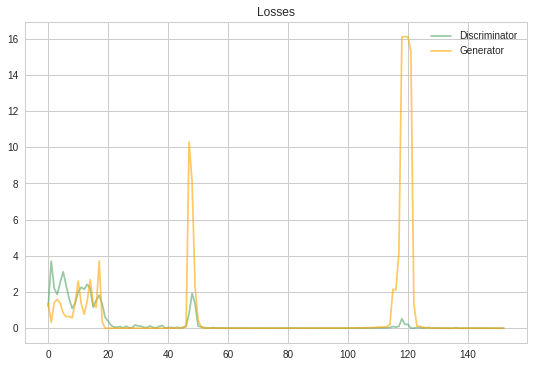

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

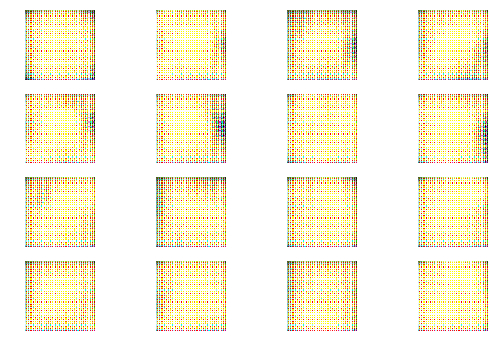


  0%|          | 1/300 [04:18<21:28:07, 258.49s/it]

(64, 64, 64, 3)
Epoch: 2/300 | Step: 1/153 [D loss: 0.0073, acc.: 100.00%] [G loss: 0.0016]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 2/153 [D loss: 0.0024, acc.: 100.00%] [G loss: 0.0016]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 3/153 [D loss: 0.0059, acc.: 100.00%] [G loss: 0.0016]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 4/153 [D loss: 0.0018, acc.: 100.00%] [G loss: 0.0023]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 5/153 [D loss: 0.0025, acc.: 100.00%] [G loss: 0.0021]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 6/153 [D loss: 0.0034, acc.: 100.00%] [G loss: 0.0017]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 7/153 [D loss: 0.0014, acc.: 100.00%] [G loss: 0.0028]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 8/153 [D loss: 0.0009, acc.: 100.00%] [G loss: 0.0021]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 9/153 [D loss: 0.0017, acc.: 100.00%] [G loss: 0.0019]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 10/153 [D loss: 0.0012, acc.: 100.00%] [G loss: 0.0033]
(64, 64, 64, 3)
Epoch: 2/300 | Step: 11/153 [D loss: 0.0025, acc.: 100.00%] [G 

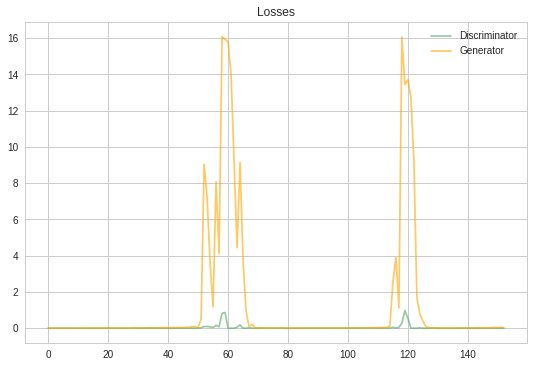

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

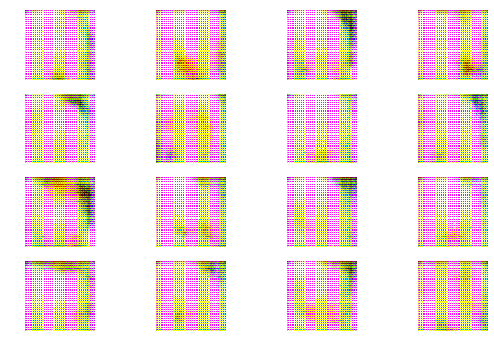


  1%|          | 2/300 [08:30<21:14:35, 256.63s/it]

(64, 64, 64, 3)
Epoch: 3/300 | Step: 1/153 [D loss: 0.0072, acc.: 99.22%] [G loss: 0.0262]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 2/153 [D loss: 0.0155, acc.: 99.22%] [G loss: 0.0162]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 3/153 [D loss: 0.0035, acc.: 100.00%] [G loss: 0.0137]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 4/153 [D loss: 0.0091, acc.: 100.00%] [G loss: 0.0467]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 5/153 [D loss: 0.0034, acc.: 100.00%] [G loss: 0.0751]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 6/153 [D loss: 0.0046, acc.: 100.00%] [G loss: 0.0931]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 7/153 [D loss: 0.0077, acc.: 100.00%] [G loss: 0.0928]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 8/153 [D loss: 0.0195, acc.: 100.00%] [G loss: 0.3033]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 9/153 [D loss: 0.0174, acc.: 100.00%] [G loss: 0.9512]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 10/153 [D loss: 0.0741, acc.: 98.44%] [G loss: 2.3604]
(64, 64, 64, 3)
Epoch: 3/300 | Step: 11/153 [D loss: 0.0365, acc.: 99.22%] [G loss

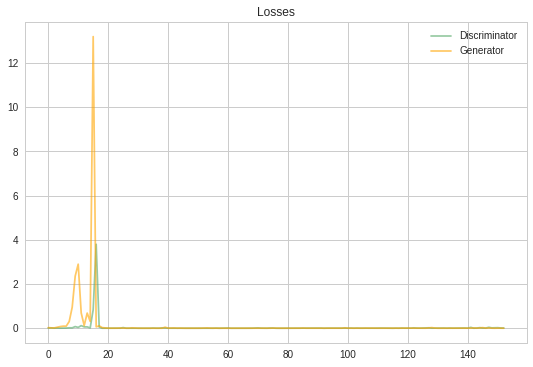

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

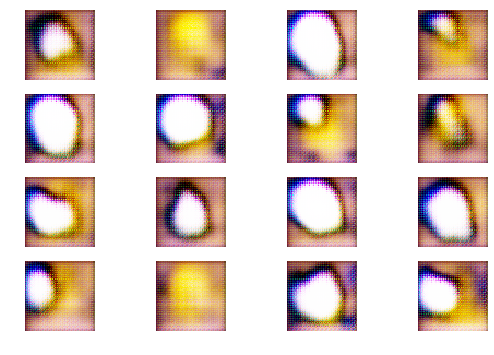


  1%|          | 3/300 [12:43<21:03:49, 255.32s/it]

(64, 64, 64, 3)
Epoch: 4/300 | Step: 1/153 [D loss: 0.0032, acc.: 100.00%] [G loss: 0.0020]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 2/153 [D loss: 0.0022, acc.: 100.00%] [G loss: 0.0018]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 3/153 [D loss: 0.0056, acc.: 100.00%] [G loss: 0.0006]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 4/153 [D loss: 0.0023, acc.: 100.00%] [G loss: 0.0006]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 5/153 [D loss: 0.0238, acc.: 100.00%] [G loss: 0.0042]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 6/153 [D loss: 0.0170, acc.: 99.22%] [G loss: 0.0016]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 7/153 [D loss: 0.0036, acc.: 100.00%] [G loss: 0.0022]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 8/153 [D loss: 0.0033, acc.: 100.00%] [G loss: 0.0025]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 9/153 [D loss: 0.0077, acc.: 100.00%] [G loss: 0.0102]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 10/153 [D loss: 0.0120, acc.: 100.00%] [G loss: 0.0097]
(64, 64, 64, 3)
Epoch: 4/300 | Step: 11/153 [D loss: 0.0048, acc.: 100.00%] [G l

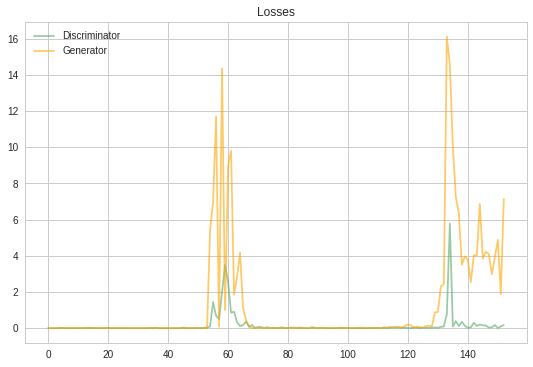

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

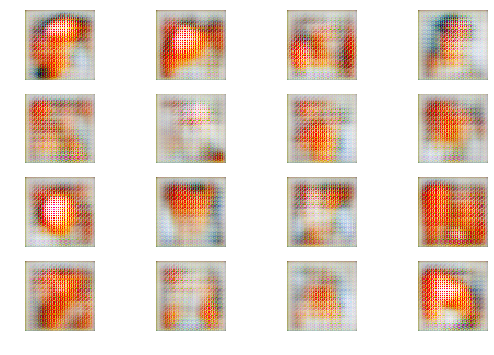


  1%|▏         | 4/300 [16:55<20:55:25, 254.48s/it]

(64, 64, 64, 3)
Epoch: 5/300 | Step: 1/153 [D loss: 0.0764, acc.: 98.44%] [G loss: 7.4112]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 2/153 [D loss: 0.1981, acc.: 93.75%] [G loss: 5.2425]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 3/153 [D loss: 0.0668, acc.: 97.66%] [G loss: 5.0214]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 4/153 [D loss: 0.8347, acc.: 59.38%] [G loss: 15.7481]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 5/153 [D loss: 2.3132, acc.: 54.69%] [G loss: 5.7116]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 6/153 [D loss: 4.7639, acc.: 50.00%] [G loss: 11.1088]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 7/153 [D loss: 0.6395, acc.: 82.03%] [G loss: 10.6344]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 8/153 [D loss: 1.7871, acc.: 45.31%] [G loss: 4.1905]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 9/153 [D loss: 0.1460, acc.: 94.53%] [G loss: 4.4884]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 10/153 [D loss: 0.0907, acc.: 96.88%] [G loss: 2.6054]
(64, 64, 64, 3)
Epoch: 5/300 | Step: 11/153 [D loss: 0.0747, acc.: 98.44%] [G loss: 2.

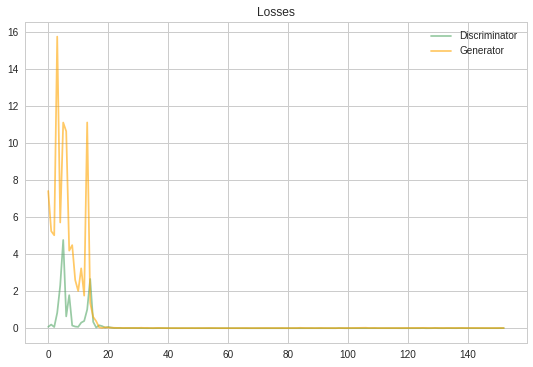

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

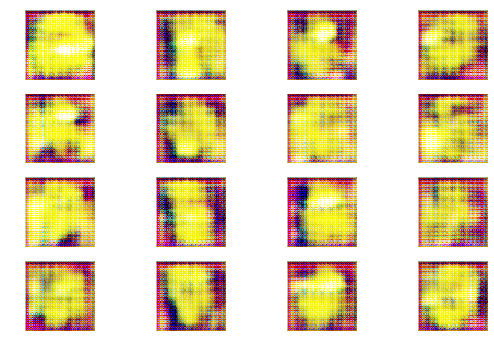


  2%|▏         | 5/300 [21:07<20:47:33, 253.74s/it]

(64, 64, 64, 3)
Epoch: 6/300 | Step: 1/153 [D loss: 0.0112, acc.: 100.00%] [G loss: 0.0128]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 2/153 [D loss: 0.0028, acc.: 100.00%] [G loss: 0.0146]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 3/153 [D loss: 0.0074, acc.: 100.00%] [G loss: 0.0106]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 4/153 [D loss: 0.0074, acc.: 100.00%] [G loss: 0.0097]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 5/153 [D loss: 0.0049, acc.: 100.00%] [G loss: 0.0101]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 6/153 [D loss: 0.0050, acc.: 100.00%] [G loss: 0.0089]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 7/153 [D loss: 0.0040, acc.: 100.00%] [G loss: 0.0121]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 8/153 [D loss: 0.0053, acc.: 100.00%] [G loss: 0.0101]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 9/153 [D loss: 0.0059, acc.: 100.00%] [G loss: 0.0128]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 10/153 [D loss: 0.0056, acc.: 100.00%] [G loss: 0.0082]
(64, 64, 64, 3)
Epoch: 6/300 | Step: 11/153 [D loss: 0.0055, acc.: 100.00%] [G 

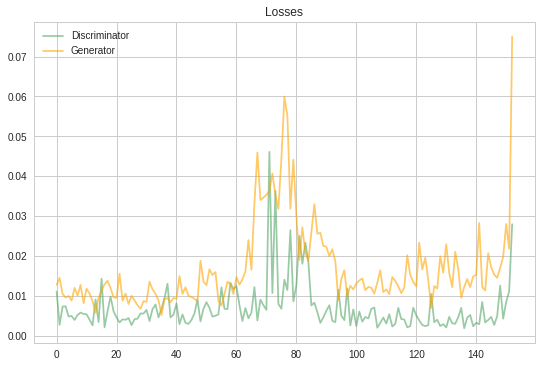

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

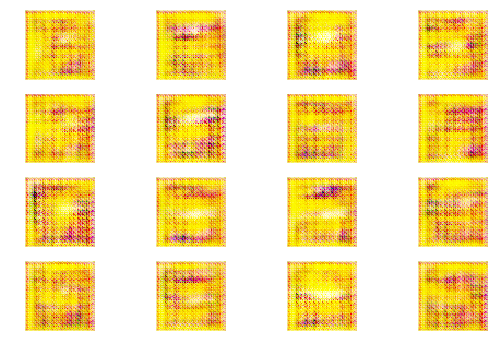


  2%|▏         | 6/300 [25:19<20:40:45, 253.22s/it]

(64, 64, 64, 3)
Epoch: 7/300 | Step: 1/153 [D loss: 0.0484, acc.: 99.22%] [G loss: 0.4589]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 2/153 [D loss: 0.2206, acc.: 85.94%] [G loss: 15.6681]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 3/153 [D loss: 0.6915, acc.: 71.88%] [G loss: 5.3077]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 4/153 [D loss: 5.6912, acc.: 50.00%] [G loss: 16.1181]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 5/153 [D loss: 0.0490, acc.: 98.44%] [G loss: 16.1181]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 6/153 [D loss: 3.0785, acc.: 59.38%] [G loss: 16.0806]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 7/153 [D loss: 0.0276, acc.: 99.22%] [G loss: 15.9517]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 8/153 [D loss: 0.0157, acc.: 98.44%] [G loss: 13.7283]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 9/153 [D loss: 1.9851, acc.: 63.28%] [G loss: 1.8350]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 10/153 [D loss: 0.1076, acc.: 95.31%] [G loss: 3.9357]
(64, 64, 64, 3)
Epoch: 7/300 | Step: 11/153 [D loss: 0.3045, acc.: 92.19%] [G loss:

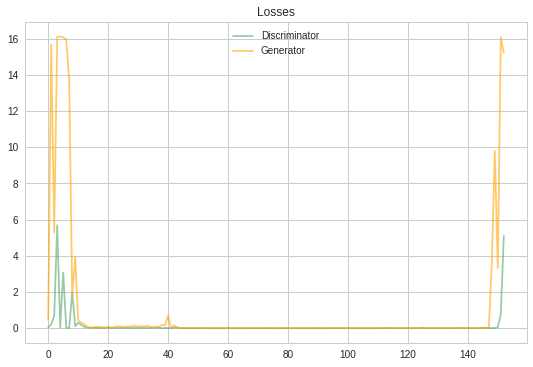

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

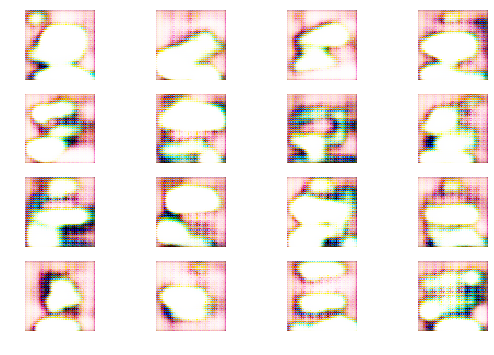


  2%|▏         | 7/300 [29:31<20:34:30, 252.80s/it]

(64, 64, 64, 3)
Epoch: 8/300 | Step: 1/153 [D loss: 0.0626, acc.: 96.09%] [G loss: 10.9275]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 2/153 [D loss: 0.0121, acc.: 100.00%] [G loss: 3.9318]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 3/153 [D loss: 0.1204, acc.: 94.53%] [G loss: 2.2619]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 4/153 [D loss: 0.0410, acc.: 98.44%] [G loss: 2.2084]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 5/153 [D loss: 0.0530, acc.: 98.44%] [G loss: 0.6944]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 6/153 [D loss: 0.1365, acc.: 94.53%] [G loss: 2.3612]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 7/153 [D loss: 0.0422, acc.: 98.44%] [G loss: 1.0513]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 8/153 [D loss: 0.1208, acc.: 96.88%] [G loss: 1.0231]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 9/153 [D loss: 0.0962, acc.: 96.09%] [G loss: 2.7700]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 10/153 [D loss: 0.1607, acc.: 92.97%] [G loss: 3.2204]
(64, 64, 64, 3)
Epoch: 8/300 | Step: 11/153 [D loss: 0.0599, acc.: 99.22%] [G loss: 1.9

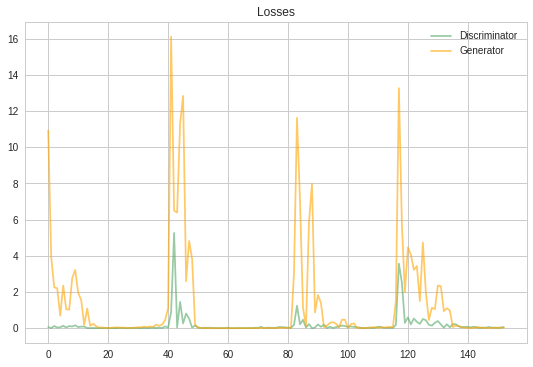

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

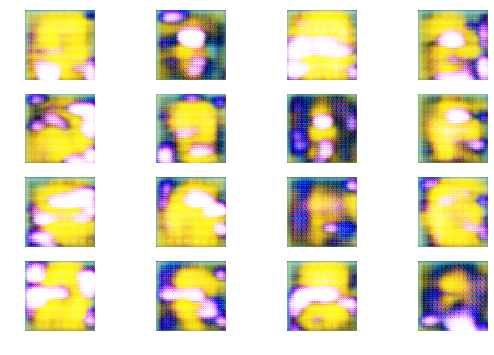


  3%|▎         | 8/300 [33:43<20:29:35, 252.66s/it]

(64, 64, 64, 3)
Epoch: 9/300 | Step: 1/153 [D loss: 0.0713, acc.: 100.00%] [G loss: 0.0135]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 2/153 [D loss: 0.1012, acc.: 98.44%] [G loss: 0.0713]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 3/153 [D loss: 0.0140, acc.: 100.00%] [G loss: 0.1045]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 4/153 [D loss: 0.0980, acc.: 96.88%] [G loss: 0.1005]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 5/153 [D loss: 0.0432, acc.: 100.00%] [G loss: 0.0289]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 6/153 [D loss: 0.0216, acc.: 100.00%] [G loss: 0.0898]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 7/153 [D loss: 0.0501, acc.: 100.00%] [G loss: 0.0412]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 8/153 [D loss: 0.0517, acc.: 100.00%] [G loss: 0.0605]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 9/153 [D loss: 0.0496, acc.: 100.00%] [G loss: 0.0288]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 10/153 [D loss: 0.0501, acc.: 99.22%] [G loss: 0.0481]
(64, 64, 64, 3)
Epoch: 9/300 | Step: 11/153 [D loss: 0.0751, acc.: 99.22%] [G loss

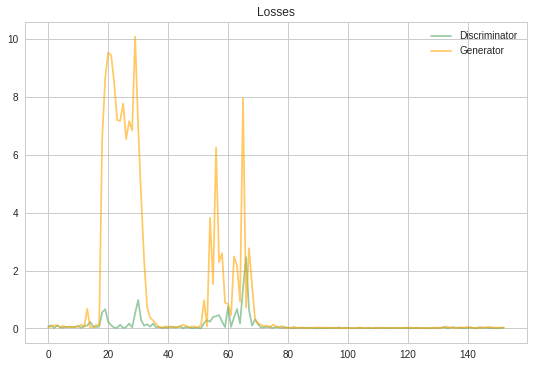

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [0]:
for epoch in tqdm(range(EPOCHS)):
  epoch += 1 #start from 1
  # So, need to append d_loss, g_loss, and step to a dataframe with epoch as 
  # a master index
  d_loss_list = []
  g_loss_list = []
  for step in range(steps_per_epoch):
    step += 1 #start from 1

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half of images
    idx = np.random.randint(0, images.shape[0], batch_size)
    imgs = images[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, NOISE_SIZE))
    gen_imgs = model_generator.predict(noise)

    
    print(gen_imgs.shape)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = model_discriminator.train_on_batch(imgs, valid)
    d_loss_fake = model_discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = model_combined.train_on_batch(noise, valid)

    # Plot the progress
    print ("Epoch: {}/{} | Step: {}/{} [D loss: {:.4f}, acc.: {:.2f}%] [G loss: {:.4f}]".format(
                epoch, EPOCHS, step, steps_per_epoch, d_loss[0], 100*d_loss[1], g_loss
            ))
    
    # Append d_loss, g_loss, and step to a dataframe
    #step_df = df.append({'d_loss' : d_loss[0], 'g_loss' : g_loss}, ignore_index=True)
    
    d_loss_zero = d_loss[0]
    
    d_loss_list.append(d_loss_zero)
    g_loss_list.append(g_loss)


  # Plot Loss
  fig, ax = plt.subplots()                      
  plt.plot(steps_list, d_loss_list, label='Discriminator', alpha=0.6, color='g')
  plt.plot(steps_list, g_loss_list, label='Generator', alpha=0.6, color='orange')
  plt.title("Losses")
  plt.legend()                      
  plt.show()

  # Plot images

  #model_generator.save("g{}.h5".format(epoch))

  gen_imgs = model_generator.predict(noise)

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :, :, :])
      axs[i,j].axis('off')
      cnt += 1
  plt.show()
  plt.close()
  
  if epoch % 10 == 0:
    model_generator.save("g{}.h5".format(epoch))
